## Training attention based model

In [1]:
%matplotlib inline

import sys
sys.path.append("../../")

from train_model import train

from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot, PredictionError

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 4)
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'
rcParams['axes.facecolor'] = '#ffffff'
rcParams['lines.linewidth'] = 2.0

In [4]:
##BEST IT

hyperparameter={
"num_nearest":40,
"sigma":2,
"geointerpolation": 'asi_multi',
'type_compat_funct_eucli':'identity',
'Num_heads':8,
"learning_rate":0.001,
"batch_size":250,
"num_neuron":60,
"num_layers":5,
"size_embedded":50,
"num_nearest_geo":30,
"num_nearest_eucli":25,
"id_dataset":'IT',
"epochs":300,
"optimier":'adam',
"validation_split":0.1,
"label":'asi_IT',
"early_stopping": False,
'scale_log':False,
"graph_label":'matrix',
}

In [5]:
spatial = train(**hyperparameter)

In [ ]:
dataset,\
result,\
fit,\
embedded_train,\
embedded_test,\
predict_regression_train,\
predict_regression_test = spatial()

In [7]:
print('################# Test ##########################')
print('MALE test:.... {}'.format(result[0]))
print('RMSE test:.... {}'.format(result[1]))
print('MAPE test:.... {}'.format(result[2]))
print('################# Train ##########################')
print('MALE train:.... {}'.format(result[3]))
print('RMSE train:.... {}'.format(result[4]))
print('MAPE train:.... {}'.format(result[5]))

################# Test ##########################
MALE test:.... 31132.930848826105
RMSE test:.... 45833.085677218165
MAPE test:.... 9.546256876803753
################# Train ##########################
MALE train:.... 29163.78694747662
RMSE train:.... 44216.91990476124
MAPE train:.... 8.372248263888888


In [8]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


## Base models benchmarking 

In [38]:
X_train ,X_test, y_train , y_test = dataset.X_train,dataset.X_test,dataset.y_train,dataset.y_test

In [39]:
import numpy as np

# For X_train
unique_X_train, index_X_train, counts_X_train = np.unique(X_train, axis=0, return_index=True, return_counts=True)
duplicated_X_train = len(X_train) - len(unique_X_train)
print(f"Duplicated rows in X_train: {duplicated_X_train}")

# For X_test
unique_X_test, index_X_test, counts_X_test = np.unique(X_test, axis=0, return_index=True, return_counts=True)
duplicated_X_test = len(X_test) - len(unique_X_test)
print(f"Duplicated rows in X_test: {duplicated_X_test}")


Duplicated rows in X_train: 1013
Duplicated rows in X_test: 76


In [ ]:

# Define the mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists to store test set evaluation metrics for each model
test_mae_list = {}
test_mse_list = {}
test_rmse_list = {}
test_r2_list = {}
test_mape_list = {}

# Define the models and their respective parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [5, 10, 15, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 9, 12, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 150], 'max_depth': [8, 12, 16]}
    },
    'SVM': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [1000, 2000], 'learning_rate': [0.01, 0.05, 0.1]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, n_estimators=2000),
        'params': {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05]}
    },
    'XGBoost': {
        'model': XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42),
        'params': {'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1]}
    }
}

# Define the K-fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# For each model
for name, model_info in models.items():
    test_mae_list[name] = []
    test_mse_list[name] = []
    test_rmse_list[name] = []
    test_r2_list[name] = []
    test_mape_list[name] = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Grid Search for hyperparameter tuning
        grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        grid_result = grid.fit(X_train_fold, y_train_fold)
        best_model = grid_result.best_estimator_

        # Make predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Evaluate the model on the test set
        test_mae = mean_absolute_error((y_test), (y_pred_test))
        test_mse = mean_squared_error((y_test), (y_pred_test))
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score((y_test), (y_pred_test))
        test_mape = mean_absolute_percentage_error((y_test), (y_pred_test))

        # Store the test set metrics in the lists
        test_mae_list[name].append(test_mae)
        test_mse_list[name].append(test_mse)
        test_rmse_list[name].append(test_rmse)
        test_r2_list[name].append(test_r2)
        test_mape_list[name].append(test_mape)

    # Calculate the average and best metrics for the test set
    avg_test_mae = np.mean(test_mae_list[name])
    avg_test_mse = np.mean(test_mse_list[name])
    avg_test_rmse = np.mean(test_rmse_list[name])
    avg_test_r2 = np.mean(test_r2_list[name])
    avg_test_mape = np.mean(test_mape_list[name])

    best_test_mae = np.min(test_mae_list[name])
    best_test_mse = np.min(test_mse_list[name])
    best_test_rmse = np.min(test_rmse_list[name])
    best_test_r2 = np.max(test_r2_list[name])
    best_test_mape = np.min(test_mape_list[name])

    print(f"Test Set Evaluation for {name}")
    print(f"Average Test MAE: {avg_test_mae}, Best Test MAE: {best_test_mae}")
    print(f"Average Test MSE: {avg_test_mse}, Best Test MSE: {best_test_mse}")
    print(f"Average Test RMSE: {avg_test_rmse}, Best Test RMSE: {best_test_rmse}")
    print(f"Average Test R2: {avg_test_r2}, Best Test R2: {best_test_r2}")
    print(f"Average Test MAPE: {avg_test_mape}, Best Test MAPE: {best_test_mape}")
    print("\n")


## Testing the embeddings

In [ ]:


X_train ,X_test, y_train , y_test = embedded_train,embedded_test,dataset.y_train,dataset.y_test


# Initialize lists to store test set evaluation metrics for each model
test_mae_list = {}
test_mse_list = {}
test_rmse_list = {}
test_r2_list = {}
test_mape_list = {}

# Define the models and their respective parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [5, 10, 15, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 9, 12, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 150], 'max_depth': [8, 12, 16]}
    },
    'SVM': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [1000], 'learning_rate': [0.05, 0.1]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, n_estimators=2000),
        'params': {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05]}
    },
    'XGBoost': {
        'model': XGBRegressor(n_estimators=2000, learning_rate=0.05, random_state=42),
        'params': {'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1]}
    }
}

# Define the K-fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# For each model
for name, model_info in models.items():
    test_mae_list[name] = []
    test_mse_list[name] = []
    test_rmse_list[name] = []
    test_r2_list[name] = []
    test_mape_list[name] = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Grid Search for hyperparameter tuning
        grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        grid_result = grid.fit(X_train_fold, y_train_fold)
        best_model = grid_result.best_estimator_

        # Make predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Evaluate the model on the test set
        test_mae = mean_absolute_error((y_test), (y_pred_test))
        test_mse = mean_squared_error((y_test), (y_pred_test))
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score((y_test), (y_pred_test))
        test_mape = mean_absolute_percentage_error((y_test), (y_pred_test))

        # Store the test set metrics in the lists
        test_mae_list[name].append(test_mae)
        test_mse_list[name].append(test_mse)
        test_rmse_list[name].append(test_rmse)
        test_r2_list[name].append(test_r2)
        test_mape_list[name].append(test_mape)

    # Calculate the average and best metrics for the test set
    avg_test_mae = np.mean(test_mae_list[name])
    avg_test_mse = np.mean(test_mse_list[name])
    avg_test_rmse = np.mean(test_rmse_list[name])
    avg_test_r2 = np.mean(test_r2_list[name])
    avg_test_mape = np.mean(test_mape_list[name])

    best_test_mae = np.min(test_mae_list[name])
    best_test_mse = np.min(test_mse_list[name])
    best_test_rmse = np.min(test_rmse_list[name])
    best_test_r2 = np.max(test_r2_list[name])
    best_test_mape = np.min(test_mape_list[name])

    print(f"Test Set Evaluation for {name}")
    print(f"Average Test MAE: {avg_test_mae}, Best Test MAE: {best_test_mae}")
    print(f"Average Test MSE: {avg_test_mse}, Best Test MSE: {best_test_mse}")
    print(f"Average Test RMSE: {avg_test_rmse}, Best Test RMSE: {best_test_rmse}")
    print(f"Average Test R2: {avg_test_r2}, Best Test R2: {best_test_r2}")
    print(f"Average Test MAPE: {avg_test_mape}, Best Test MAPE: {best_test_mape}")
    print("\n")


## Applying pca

In [33]:
from sklearn.decomposition import PCA

# Apply PCA to embedded_train and embedded_test to reduce embeddings to 12 dimensions
pca = PCA(n_components=6)
embedded_train_pca = pca.fit_transform(embedded_train)
embedded_test_pca = pca.transform(embedded_test)

# Concatenate dataset.X_train with embedded_train_pca and dataset.X_test with embedded_test_pca
X_train_concat = np.concatenate((dataset.X_train, embedded_train_pca), axis=1)
X_test_concat = np.concatenate((dataset.X_test, embedded_test_pca), axis=1)

In [29]:
X_train_concat = np.concatenate((dataset.X_train, embedded_train), axis=1)
X_test_concat = np.concatenate((dataset.X_test, embedded_test), axis=1)

In [34]:
X_train ,X_test, y_train , y_test = X_train_concat,X_test_concat,dataset.y_train,dataset.y_test

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15107
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 74
[LightGBM] [Info] Start training from score 268770.931835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15107
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 74
[LightGBM] [Info] Start training from score 268770.931835


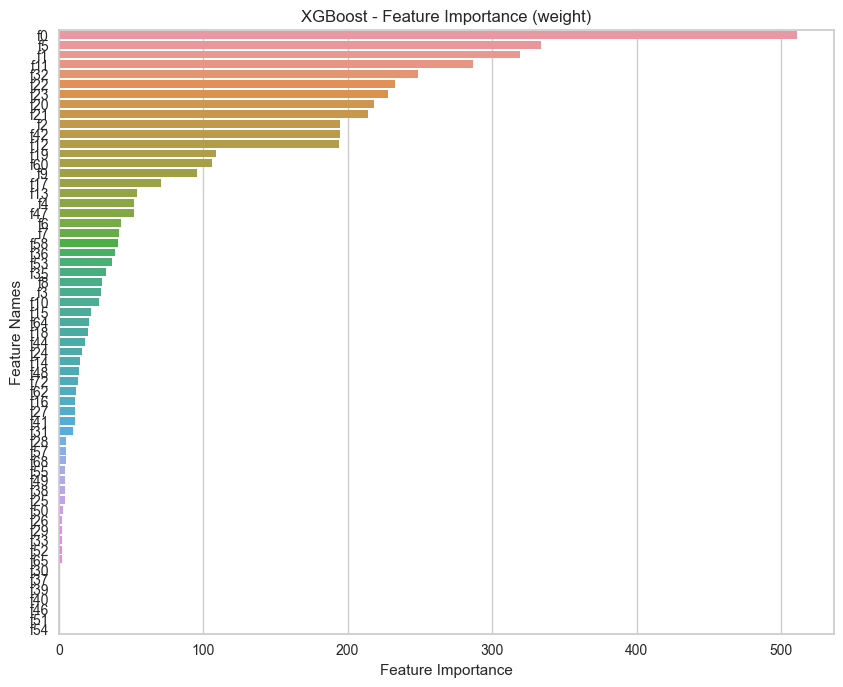

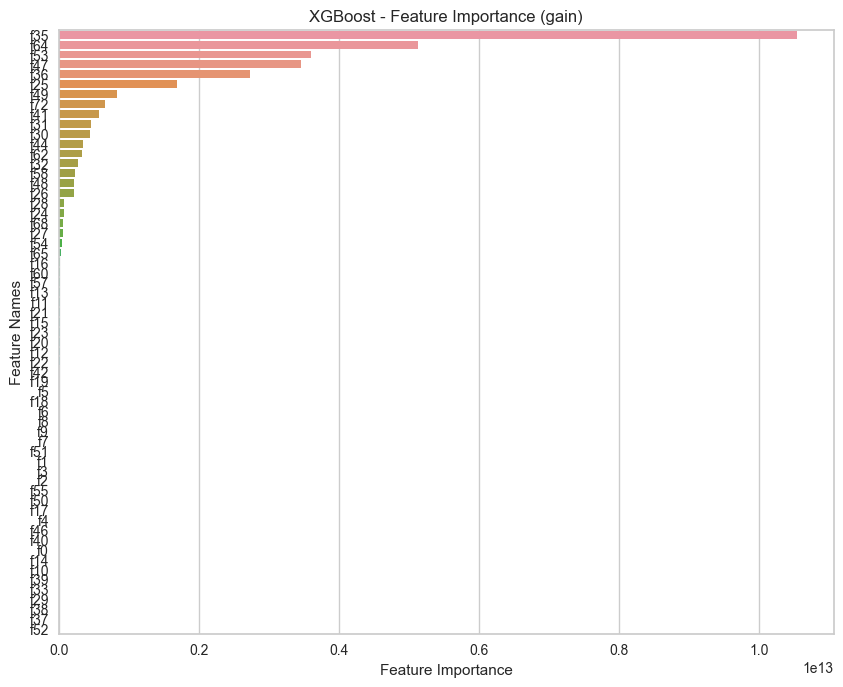

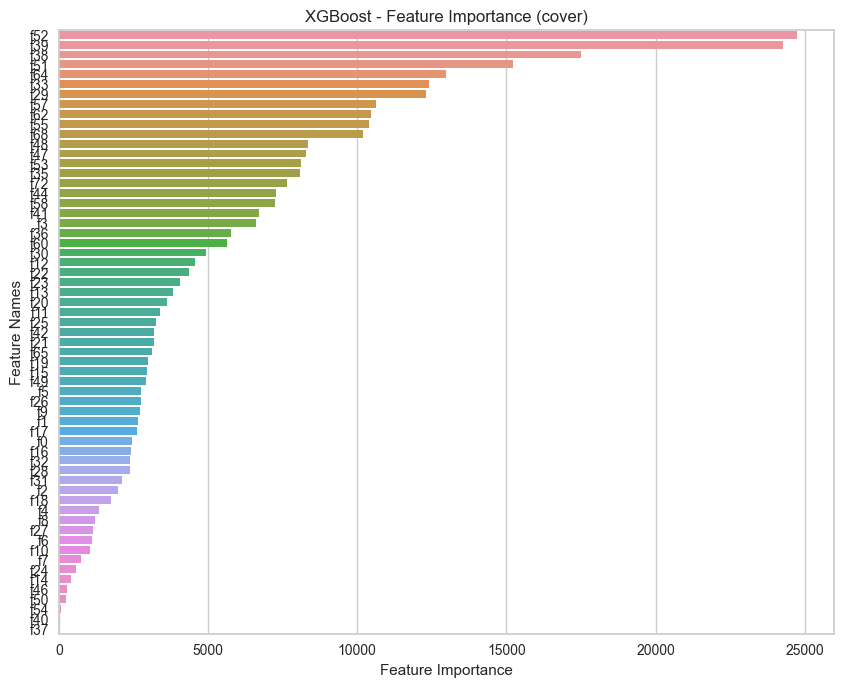

ValueError: All arrays must be of the same length

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# Original feature names

# Initialize the Standard Scaler
scaler = MinMaxScaler()

# Replace with your actual data
# X_train and y_train should be your real training data
# X_train = your_data_here
# y_train = your_target_here
feature_names = ['latitude', 'longitude', 'neighborhood', 'property_type', 'property_class', 
                 'surface', 'bedrooms', 'bathrooms', 'lift', 'total_building_floors', 'garage_box', 
                 'condominium_expenses', 'year_of_construction', 'state', 'heating_type', 'common_garden', 
                 'city', 'energyClass', 'basement', 'mean_floor', 'nearest_hospital', 'nearest_transportation', 
                 'nearest_supermarket', 'distance_to_city_center']

# Function to generate PCA feature names
def generate_pca_feature_names(n_features):
    return [f'PCA_Feature_{i+1}' for i in range(n_features)]

# Choose the number of PCA features dynamically
n_features = 6  # Or you could use: int(input("Enter the number of PCA features you want: "))
pca_feature_names = generate_pca_feature_names(n_features)
feature_names.extend(pca_feature_names)
# Scale the features between 0 and 1
X_train = scaler.fit_transform(X_train)

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type, importance_type):
    data = {'feature_names': names, 'feature_importance': importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'{model_type} - Feature Importance ({importance_type})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

# Function to get and plot XGBoost feature importance
def xgb_importance(model, importance_type, feature_names):
    importance = model.get_booster().get_score(importance_type=importance_type)
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    features, values = zip(*sorted_importance)
    plot_feature_importance(values, features, 'XGBoost', importance_type)

# Function to get and plot LightGBM feature importance
def lgbm_importance(model, importance_type, feature_names):
    importance = model.feature_importances_
    plot_feature_importance(importance, feature_names, 'LightGBM', importance_type)

# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Train LightGBM model
lgbm_model_gain = LGBMRegressor(importance_type='gain')
lgbm_model_gain.fit(X_train, y_train)
lgbm_model_split = LGBMRegressor(importance_type='split')
lgbm_model_split.fit(X_train, y_train)

# Plot feature importance
for importance_type in ['weight', 'gain', 'cover']:
    xgb_importance(xgb_model, importance_type, feature_names)

lgbm_importance(lgbm_model_gain, 'gain', feature_names)
lgbm_importance(lgbm_model_split, 'split', feature_names)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 30
[LightGBM] [Info] Start training from score 268770.931835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3887
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 30
[LightGBM] [Info] Start training from score 268770.931835


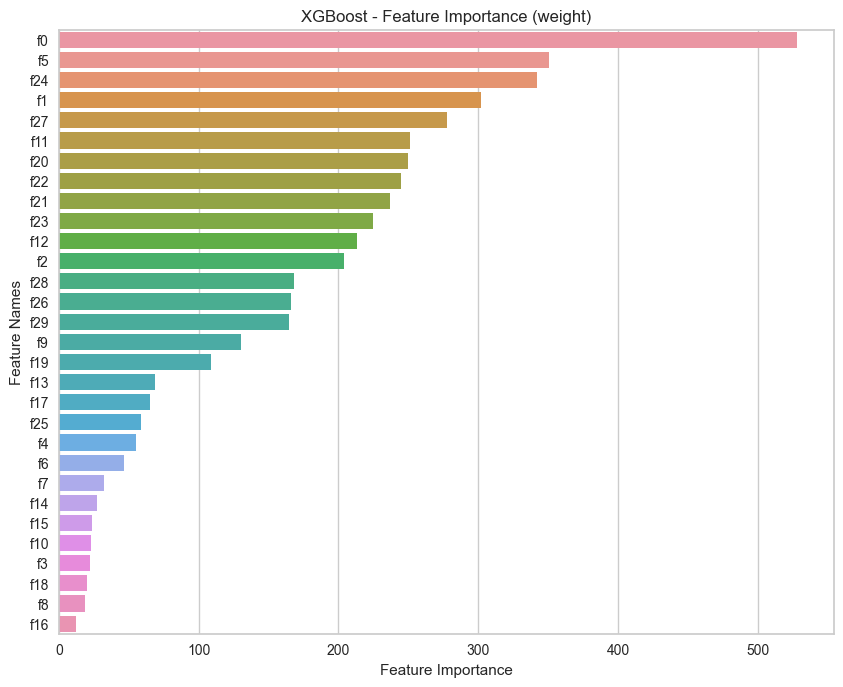

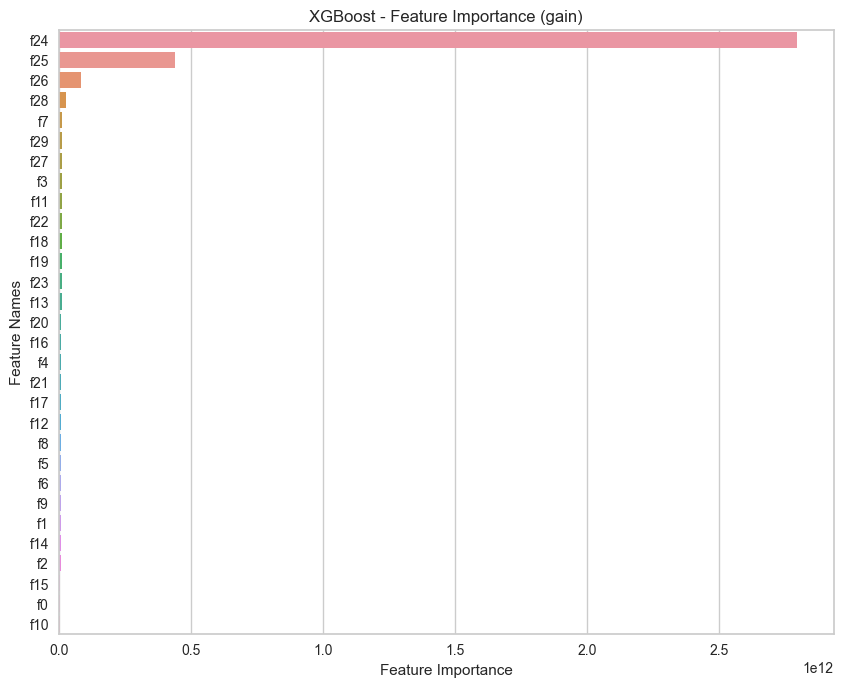

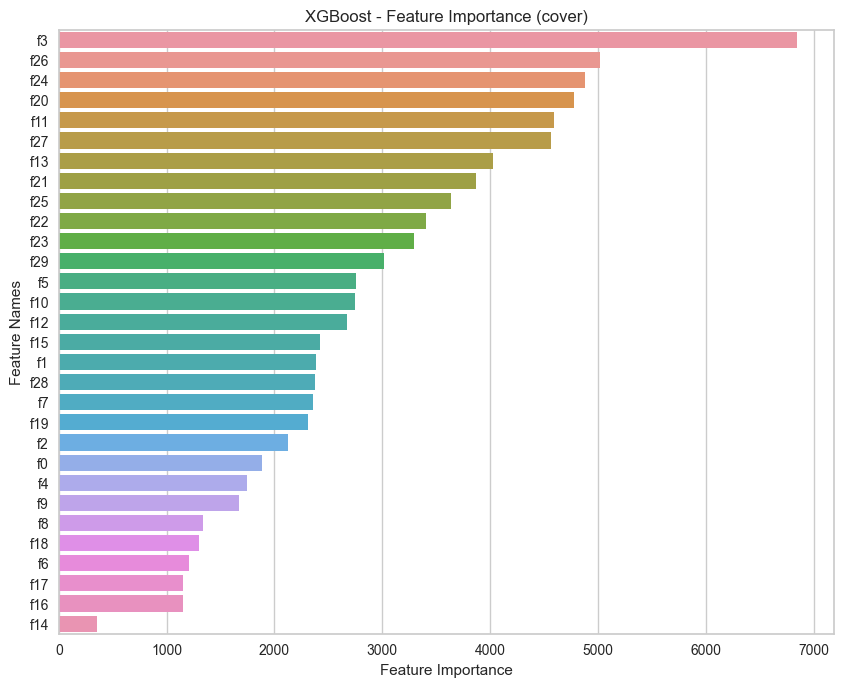

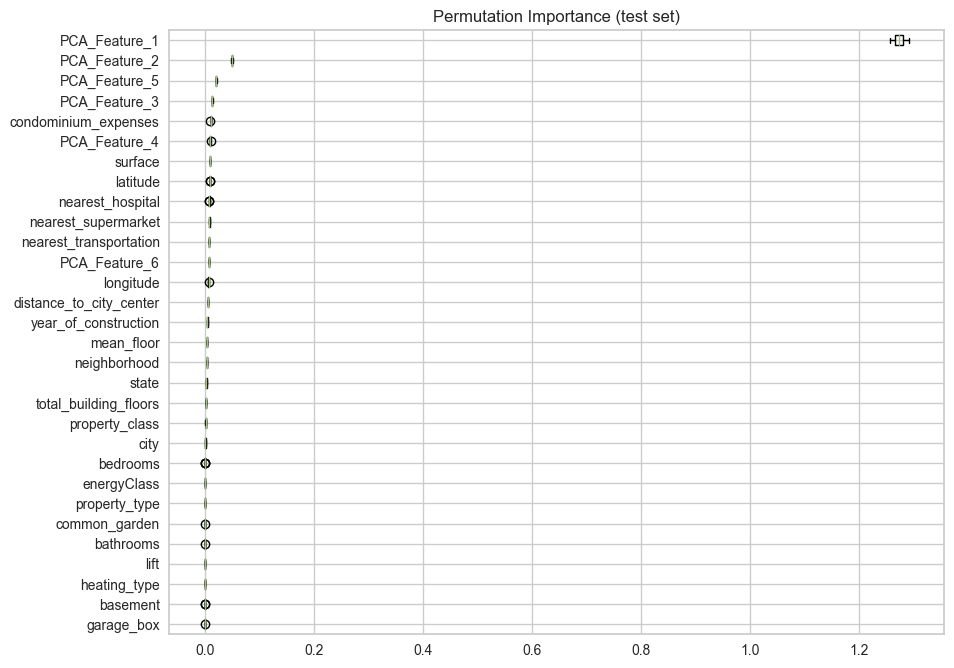

In [35]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

# Initialize the Standard Scaler
scaler = MinMaxScaler()

# Your actual data should replace these
# X_train = your_data_here
# y_train = your_target_here

# Original feature names
feature_names = ['latitude', 'longitude', 'neighborhood', 'property_type', 'property_class', 
                 'surface', 'bedrooms', 'bathrooms', 'lift', 'total_building_floors', 'garage_box', 
                 'condominium_expenses', 'year_of_construction', 'state', 'heating_type', 'common_garden', 
                 'city', 'energyClass', 'basement', 'mean_floor', 'nearest_hospital', 'nearest_transportation', 
                 'nearest_supermarket', 'distance_to_city_center']

# Generate PCA feature names
def generate_pca_feature_names(n_features):
    return [f'PCA_Feature_{i+1}' for i in range(n_features)]

n_features = 6
pca_feature_names = generate_pca_feature_names(n_features)
feature_names.extend(pca_feature_names)

# Scale the features
X_train = scaler.fit_transform(X_train)

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type, importance_type):
    data = {'feature_names': names, 'feature_importance': importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'{model_type} - Feature Importance ({importance_type})')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

# Train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Train LightGBM model
lgbm_model_gain = LGBMRegressor(importance_type='gain')
lgbm_model_gain.fit(X_train, y_train)
lgbm_model_split = LGBMRegressor(importance_type='split')
lgbm_model_split.fit(X_train, y_train)

# Plot native feature importance
for importance_type in ['weight', 'gain', 'cover']:
    xgb_importance(xgb_model, importance_type, feature_names)

# Permutation Importance
result = permutation_importance(xgb_model, X_train, y_train, n_repeats=30, random_state=0)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
plt.show()


In [ ]:


# Initialize lists to store test set evaluation metrics for each model
test_mae_list = {}
test_mse_list = {}
test_rmse_list = {}
test_r2_list = {}
test_mape_list = {}

# Define the models and their respective parameter grids
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [5, 10, 15, 20]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [5, 9, 12, 15]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [50, 100, 150], 'max_depth': [8, 12, 16]}
    },
    'SVM': {
        'model': SVR(),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'LightGBM': {
        'model': LGBMRegressor(),
        'params': {'n_estimators': [1000], 'learning_rate': [0.05, 0.1]}
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0, n_estimators=2000),
        'params': {'depth': [6, 8, 10], 'learning_rate': [0.01, 0.05]}
    },
    'XGBoost': {
        'model': XGBRegressor(n_estimators=2000, learning_rate=0.05, random_state=42),
        'params': {'max_depth': [5, 7, 9], 'learning_rate': [0.01, 0.05, 0.1]}
    }
}

# Define the K-fold cross-validator
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# For each model
for name, model_info in models.items():
    test_mae_list[name] = []
    test_mse_list[name] = []
    test_rmse_list[name] = []
    test_r2_list[name] = []
    test_mape_list[name] = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Grid Search for hyperparameter tuning
        grid = GridSearchCV(estimator=model_info['model'], param_grid=model_info['params'], cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
        grid_result = grid.fit(X_train_fold, y_train_fold)
        best_model = grid_result.best_estimator_

        # Make predictions on the test set
        y_pred_test = best_model.predict(X_test)

        # Evaluate the model on the test set
        test_mae = mean_absolute_error((y_test), (y_pred_test))
        test_mse = mean_squared_error((y_test), (y_pred_test))
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score((y_test), (y_pred_test))
        test_mape = mean_absolute_percentage_error((y_test), (y_pred_test))

        # Store the test set metrics in the lists
        test_mae_list[name].append(test_mae)
        test_mse_list[name].append(test_mse)
        test_rmse_list[name].append(test_rmse)
        test_r2_list[name].append(test_r2)
        test_mape_list[name].append(test_mape)

    # Calculate the average and best metrics for the test set
    avg_test_mae = np.mean(test_mae_list[name])
    avg_test_mse = np.mean(test_mse_list[name])
    avg_test_rmse = np.mean(test_rmse_list[name])
    avg_test_r2 = np.mean(test_r2_list[name])
    avg_test_mape = np.mean(test_mape_list[name])

    best_test_mae = np.min(test_mae_list[name])
    best_test_mse = np.min(test_mse_list[name])
    best_test_rmse = np.min(test_rmse_list[name])
    best_test_r2 = np.max(test_r2_list[name])
    best_test_mape = np.min(test_mape_list[name])

    print(f"Test Set Evaluation for {name}")
    print(f"Average Test MAE: {avg_test_mae}, Best Test MAE: {best_test_mae}")
    print(f"Average Test MSE: {avg_test_mse}, Best Test MSE: {best_test_mse}")
    print(f"Average Test RMSE: {avg_test_rmse}, Best Test RMSE: {best_test_rmse}")
    print(f"Average Test R2: {avg_test_r2}, Best Test R2: {best_test_r2}")
    print(f"Average Test MAPE: {avg_test_mape}, Best Test MAPE: {best_test_mape}")
    print("\n")
